# Coursework 1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Paperspace, where you can access GPUs.

You should receive an email at your imperial address inviting you to join the course team on PaperSpace (within a day of the coursework being released).

#### Paperspace
See [the Paperspace information doc](https://hackmd.io/@afspies/S1stL8Qnt). 

The public tests are embedded within the notebook. You can ignore the "tests" folder as it is only required for colab.


#### Google Colab
To run this notebook on Google Colab, please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

In [27]:
!pip install -q otter-grader pandoc torch torchvision sklearn seaborn

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [25]:
# Initialization Cell
import otter
grader = otter.Notebook("dl_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

ModuleNotFoundError: ignored

## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass
        ...
        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        if type(kernel_size) == int:
          self.w = torch.zeros(out_channels, in_channels, kernel_size, kernel_size)
        else:
          self.w = torch.zeros(out_channels, in_channels, kernel_size[0], kernel_size[1])
        # Bias should have shape [out_channels] 
        self.b = torch.zeros(out_channels)
        self.F = out_channels
        self.C = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass                                     #
        k = self.kernel_size
        stride = self.stride
        h_in, w_in = x.shape[2], x.shape[3]

        padding = self.padding  # + k//2
        batch_size = x.shape[0]

        h_out = (h_in + 2 * padding - (k - 1) - 1) / stride + 1
        w_out = (w_in + 2 * padding - (k - 1) - 1) / stride + 1
        h_out, w_out = int(h_out), int(w_out)

        inp_unf = F.unfold(x, (k, k), padding=padding)
        out_unf = inp_unf.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()).transpose(1, 2)
        out = F.fold(out_unf, (h_out, w_out), (1, 1))
        out += self.b.reshape((1,-1,1,1))
        ############ NEED TO ADD BIAS
        #print("out_unf.shape: {}".format(out_unf.shape))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out 

In [ ]:
list(Conv2d(3,7,9)(torch.zeros((10, 3,64,64))).shape)

In [ ]:
grader.check("Convolution Layer")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.kernel_size = kernel_size
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        N = x.shape[0]
        C = x.shape[1]
        kernel = self.kernel_size
        poolH = x.shape[2] // kernel
        poolW = x.shape[3] // kernel
        out = torch.zeros((x.shape[0], 
                                x.shape[1], 
                                poolH,
                                poolW))

        for i in range(N):
            for j in range(C):
                for k in range(0, x.shape[2] - kernel+1, kernel):
                    for m in range(0, x.shape[3] - kernel+1, kernel):
                        M = x[i, j, k : k+kernel, m : m+kernel]
                        out[i, j, k // kernel, m // kernel] = M.max()


        ####### NEED TO REMOVE LOOPS TO OPTIMISE
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [ ]:
list(MaxPool2d(3)(torch.zeros((10,3,64,64))).shape)

In [ ]:
grader.check("MaxPool Layer")

In [ ]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        self.w = torch.empty(out_channels, in_channels)
        self.b = torch.empty(out_channels) if bias else None
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = torch.matmul(x, self.w.t())
        if self.b is not None:
          out += self.b
          
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [ ]:
grader.check("Linear Layer")

In [ ]:
class BatchNorm2d(nn.Module):
	def __init__(self, num_features, eps=1e-05, momentum=0.1):
		super(BatchNorm2d, self).__init__()
		"""
		An implementation of a Batch Normalization over a mini-batch of 2D inputs.

		The mean and standard-deviation are calculated per-dimension over the
		mini-batches and gamma and beta are learnable parameter vectors of
		size num_features.

		Parameters:
		- num_features: C from an expected input of size (N, C, H, W).
		- eps: a value added to the denominator for numerical stability. Default: 1e-5
		- momentum: the value used for the running_mean and running_var
		computation. Default: 0.1 . (i.e. 1-momentum for running mean)
		- gamma: the learnable weights of shape (num_features).
		- beta: the learnable bias of the module of shape (num_features).
		"""
		# TODO: Define the parameters used in the forward pass                 #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		self.num_features = num_features
		self.eps = eps
		self.momentum = momentum

		# self.register_parameter is not used as it was mentioned on piazza
		# that this will be overridden
		self.gamma = torch.ones(num_features)
		self.beta = torch.zeros(num_features)

		#print("self.gamma: {}".format(self.gamma))
		#print("self.beta.shape: {}".format(self.beta.shape))
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

	def forward(self, x):
		"""
		During training this layer keeps running estimates of its computed mean and
		variance, which are then used for normalization during evaluation.
		Input:
		- x: Input data of shape (N, C, H, W)
		Output:
		- out: Output data of shape (N, C, H, W) (same shape as input)
		"""
		# TODO: Implement the forward pass                                     #
		#       (be aware of the difference for training and testing)          #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

		N = x.shape[0]
		C = x.shape[1]
		
		# testing
		if not torch.is_grad_enabled():
			for i in range(N):
				for j in range(C):
					x[i,j] = (x - self.beta[j]) / torch.sqrt(self.gamma[j] + self.eps)
		
		# training
		else:
			mean = x.mean(dim=(2,3), keepdim=True)
			var = ((x - mean) ** 2).mean(dim=(2,3), keepdim=True)
			
			#print("mean shape: {}".format(mean.shape))
			#print("var shape: {}".format(var.shape))
			x_hat = (x - mean) / torch.sqrt(var + self.eps)
			#print("x_hat shape: {}".format(x_hat.shape))
        	# Update the mean and variance using moving average
			for i in range(N):
				for j in range(C):
					self.beta[j] = (1.0 - self.momentum) * self.beta[j] + self.momentum * mean[i, j]
					self.gamma[j] = (1.0 - self.momentum) * self.gamma[j] + self.momentum * var[i, j]
					x[i, j] = self.gamma[j] * x_hat[i, j] + self.beta[j]  # Scale and shift
			#print("self.gamma.shape: {}".format(self.gamma.shape))
			#print("self.beta.shape: {}".format(self.beta.shape))
			
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		return x

In [ ]:
list(BatchNorm2d(2)(torch.zeros((3,2,7,6))).shape)

In [ ]:
grader.check("BatchNorm Layer")

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (30 points)
    * 10 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (10 points)

**Downloading NaturalImageNet**

In [9]:
ON_COLAB = True

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else: 
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

--2023-01-27 18:02:49--  https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138507970 (132M) [application/octet-stream]
Saving to: ‘NaturalImageNetTest.zip?download=1’

NaturalImageNetTest 100%[===================>] 132.09M   337KB/s    in 7m 12s  

2023-01-27 18:10:04 (313 KB/s) - ‘NaturalImageNetTest.zip?download=1’ saved [138507970/138507970]

--2023-01-27 18:10:04--  https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1383630100 (1.3G) [application/octet-stream]
Saving to: ‘NaturalImageNetTrain.zip?download=1’

NaturalImageNetTrai 100%[===================>]   1.29G  7.72MB/s    in 22

In [10]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [11]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop((256,256)),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation(degrees=50),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create train val split
n = len(train_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number! 
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

17986 1998 2000


In [12]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images** 

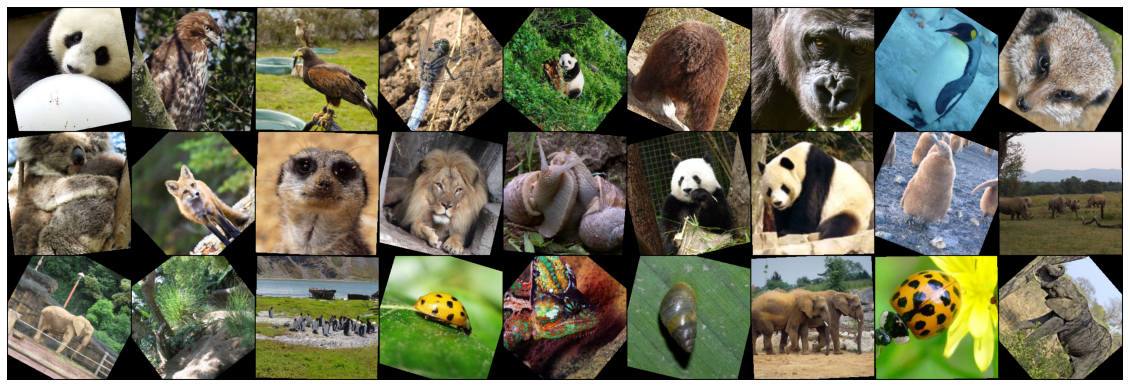

In [13]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [14]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 20):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 16
        self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(16), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride=1)
        self.layer3 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer5 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer6 = self.make_layer(ResidualBlock, 128, 2, stride = 1)
        self.layer7 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer8 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer9 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)

# Weights initialisation
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

In [15]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

conv_1 = conv_output_shape([256, 256], 3, 1)
print("conv1 shape: {}".format(conv_1))
conv_2 = conv_output_shape(conv_1, 3, 2)
print("conv2 shape: {}".format(conv_2))
conv_3 = conv_output_shape(conv_2, 3, 2)
print("conv3 shape: {}".format(conv_3))

conv1 shape: (254, 254)
conv2 shape: (126, 126)
conv3 shape: (62, 62)


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [17]:
# Early stopping

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [18]:
USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)
    

print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)

        

def train_part(model, optimizer, epochs=10, early_stopper=None):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        accuracy = check_accuracy(loader_val, model)
        early_stopping = early_stopper.early_stop(accuracy)
        if early_stopping:
          print("Entered early stopping, terminating training")
          break
                

cuda:0


Total number of parameters is: 12002052


<ipython-input-14-bf70d19648ad>:106: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
<ipython-input-14-bf70d19648ad>:103: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Epoch: 0, Iteration 0, loss = 7.7762
Epoch: 0, Iteration 10, loss = 3.5097
Epoch: 0, Iteration 20, loss = 4.9725
Epoch: 0, Iteration 30, loss = 3.2749
Epoch: 0, Iteration 40, loss = 3.6719
Epoch: 0, Iteration 50, loss = 3.4788
Epoch: 0, Iteration 60, loss = 2.8353
Epoch: 0, Iteration 70, loss = 3.0851
Epoch: 0, Iteration 80, loss = 2.7463
Epoch: 0, Iteration 90, loss = 2.6428
Epoch: 0, Iteration 100, loss = 3.1294
Epoch: 0, Iteration 110, loss = 2.9298
Epoch: 0, Iteration 120, loss = 2.6638
Epoch: 0, Iteration 130, loss = 2.8713
Epoch: 0, Iteration 140, loss = 2.7017
Got 502 / 1998 correct of val set (25.13)
Epoch: 1, Iteration 0, loss = 2.6254
Epoch: 1, Iteration 10, loss = 2.5637
Epoch: 1, Iteration 20, loss = 2.3096
Epoch: 1, Iteration 30, loss = 2.2657
Epoch: 1, Iteration 40, loss = 2.6811
Epoch: 1, Iteration 50, loss = 2.5197
Epoch: 1, Iteration 60, loss = 2.4034
Epoch: 1, Iteration 70, loss = 2.3644
Epoch: 1, Iteration 80, loss = 2.3858
Epoch: 1, Iteration 90, loss = 2.5185
Epoch

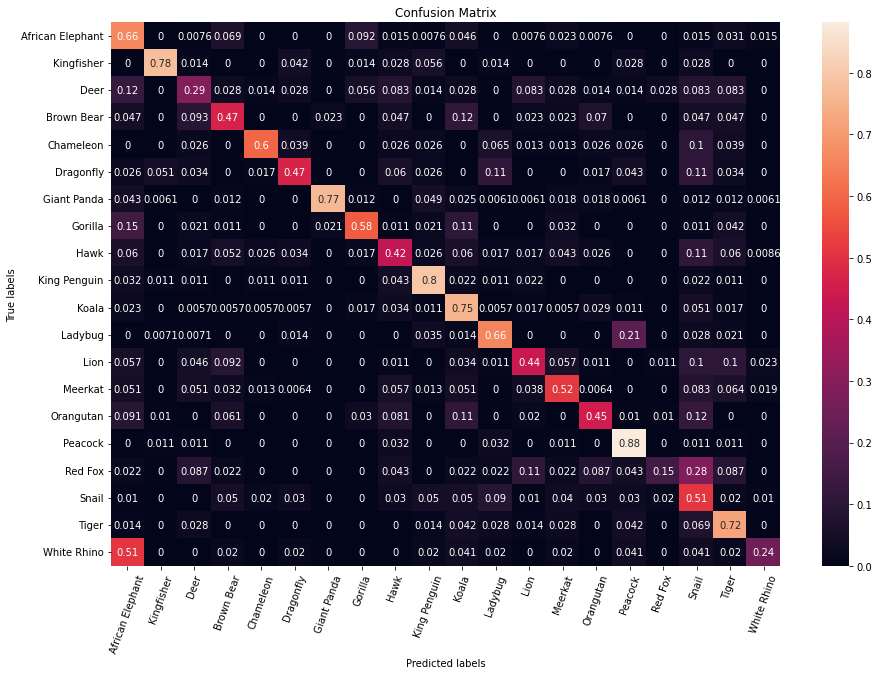

Predicted label ['Orangutan' 'Dragonfly' 'Gorilla' 'Deer' 'Ladybug' 'Kingfisher'
 'Giant Panda' 'Snail' 'Ladybug']
True label ['Giant Panda' 'Koala' 'Koala' 'Dragonfly' 'Snail' 'King Penguin'
 'Gorilla' 'Tiger' 'Peacock']
Corresponding images are shown below


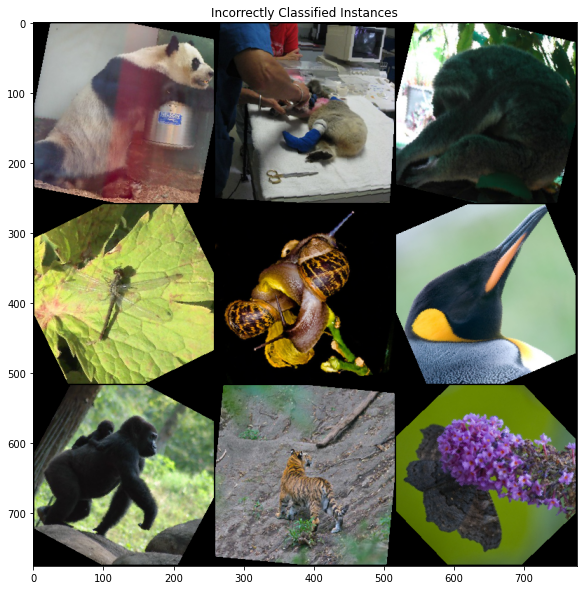

In [19]:
# define and train the network
model = MyResNet()
model.apply(init_weights)
optimizer = optim.Adamax(model.parameters()) 

early_stopper = EarlyStopper(patience=5, min_delta=0.05)

params = {
    'optimizer': [optim.Adamax(model.parameters(), lr=0.0001), optim.Adamax(model.parameters(), lr=0.001), 
                  optim.Adamax(model.parameters(), lr=0.01), optim.Adamax(model.parameters(), lr=0.1)]
}

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs = 10, early_stopper=early_stopper)


# report test set accuracy
check_accuracy(loader_val, model, analysis=True)


# save the model
torch.save(model.state_dict(), 'model.pt')

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1140 / 2000 correct of val set (57.00)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


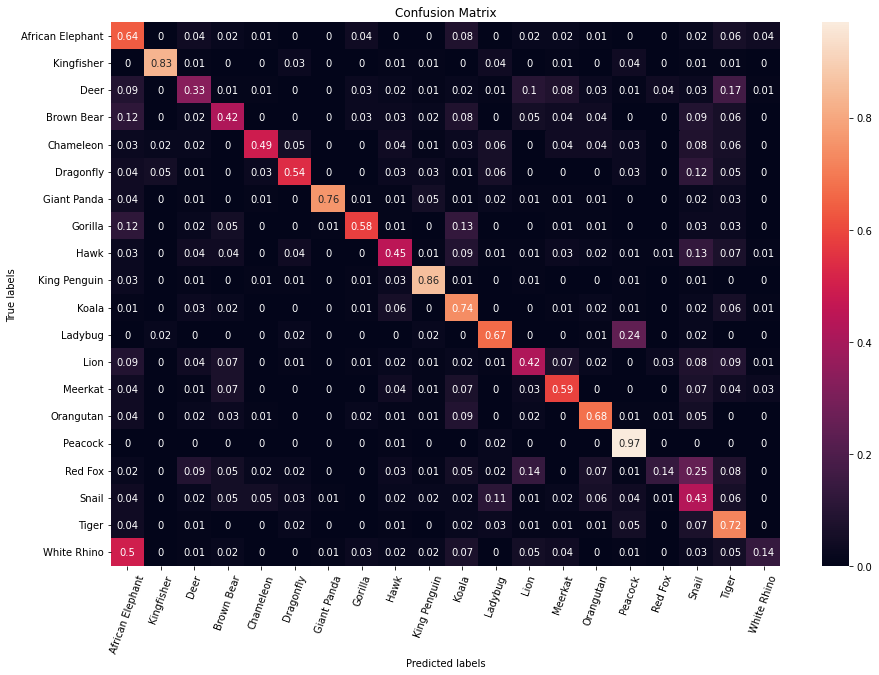

Predicted label ['Gorilla' 'Tiger' 'Lion' 'African Elephant' 'Koala' 'Tiger' 'Tiger'
 'African Elephant' 'Tiger']
True label ['African Elephant' 'Hawk' 'Deer' 'White Rhino' 'Deer' 'Red Fox' 'Red Fox'
 'Deer' 'White Rhino']
Corresponding images are shown below


0.57

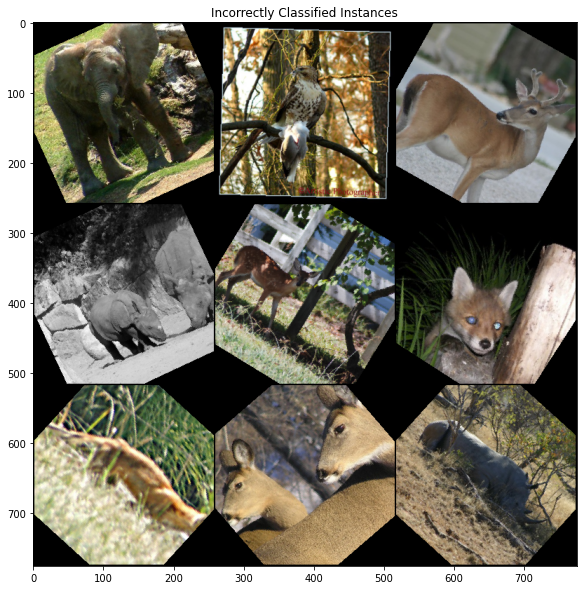

In [20]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

- Grid search involves trying every possible combination between the hyperparameters to find the optimal combination. However, this will likely take too long given large network size and data. Therefore, random search may be more suitable as it randomly selects a subset of combinations to try. An advantage to both methods is that they are paralellisable.

- Bayesian Optimisation could be a suitable strategy as at each iteration there is increased confidence in the optimal set of parameters.

- Lastly, manually guessing/trial and error is the simplest strategy for hyperparameter searching.

Overall, I believe that random search is the best strategy as it combines simplicity with effectiveness and practicality for large networks and data.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

- Added more ResidualBlock layers to make the model deeper.
  - This helps as it adds more parameters to the model, allowing it to learn and express more complicated patterns
- Added data augmentation to the transforms of the training set. 
  - This helps because the model is encouraged to learn the underlying features that distinguish each class, and to ignore random noise, e.g. from the random flips/rotations.
- Increased the number of epochs for training and added in early stopping criteria based off the validation loss. If the validation loss stops decreasing, terminate training.
  - This helps because increasing the number of epochs ensures the model has enough data to learn from. However, this risks overfitting to the training set and so early stopping prevents this by monitoring the validation loss.
- Hyperparameter tuning on optimizer (e.g. type of optimizer, learning rate) using searches to find optimal combination
  - This helps because it will result in better training as optimizers aid backpropagation, helping to reach a good local minima
  - After tuning, it was decided to go with the default Adamax parameters as these seemed to work well enough
- Added Xavier initialisation to linear and conv layers
  - Helps training and is better than 0-initialisation

---

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(: 

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

The high-level layers capture most of the information from the input, whereas the low-level layers capture specific features which are focused on. This means that as the network goes deeper, the features learned are more abstract. For example, some low-level layers may be learning patterns associated with ears (as the dataset is about natural animals), whereas the high-level layers simply capture the entire face. Thus, the low-level layers are used to distinguish between classes. The middle to high level layers also often act similar to classical computer vision algorithms, e.g. seeking to extract edges or self-learned "areas of interest". 

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

The training log shows big jumps in correct val predictions early on, and begins to reduce as training continues. This is expected and shows the model will still benefit from training. The early stopping ensures no/minimal overfitting, which is why validation accuracy is similar to test accuracy. This is important as validation set is then a good indicator for production performance. 

When analysing the confusion matrix, it is clear that the model struggles with some classes that are similar in appearance to others. For example, "White Rhino" and "African Elephant" are often confused with each other. A deeper model may be able to have enough parameters to distinguish these harder classes. 

The feature maps show that the initial layers are learning more "simple" features, for example edges. The deep layers are then learning more abstract features specific to the animals for classification. 

The performance of the network is satisfactory but not very high. The network could benefit from more training data or higher complexity through more layers. The model currently achieves a good balance between performance and complexity.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

- Space and time complexity to make predictions. These may be more important depending on application, e.g. mobile phones or real-time predictions.

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [21]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 432x288 with 0 Axes>

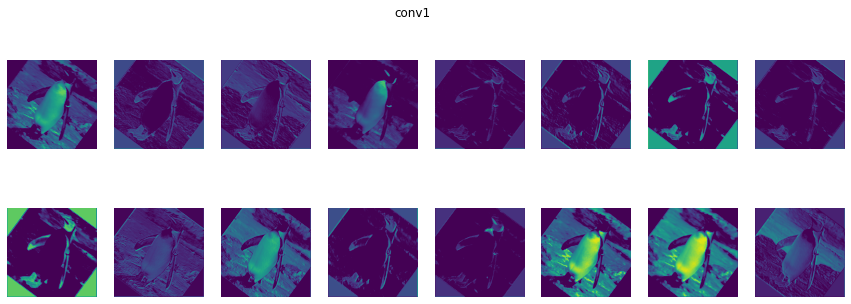

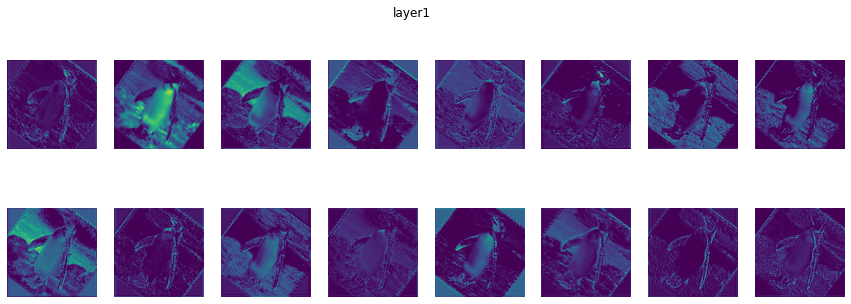

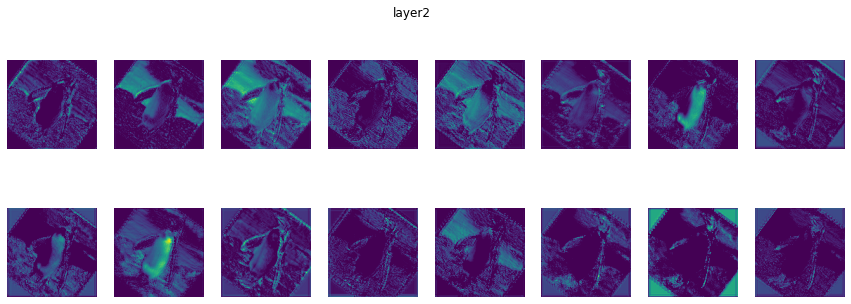

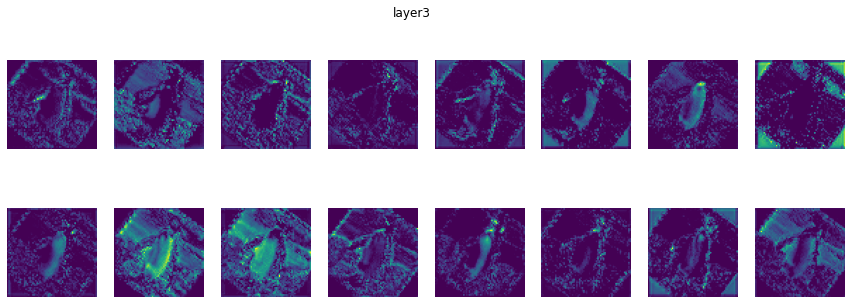

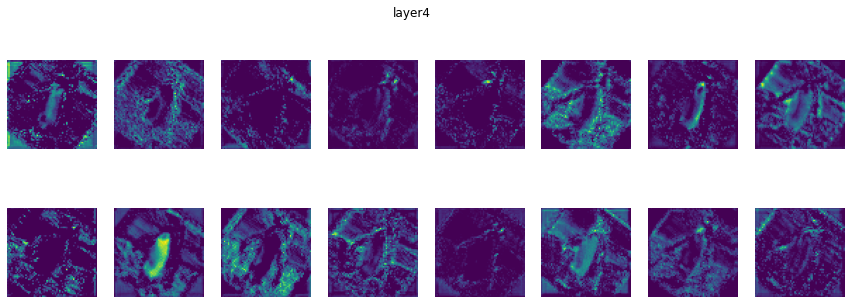

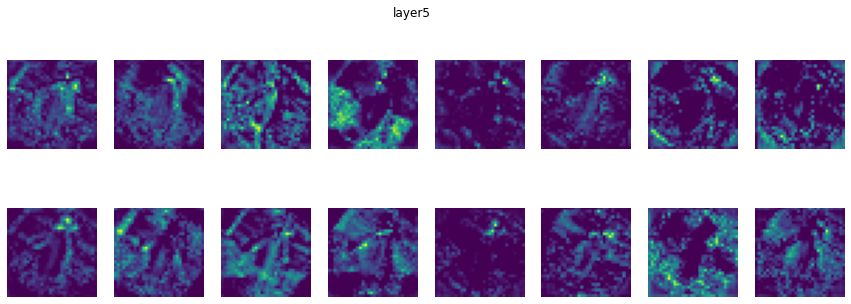

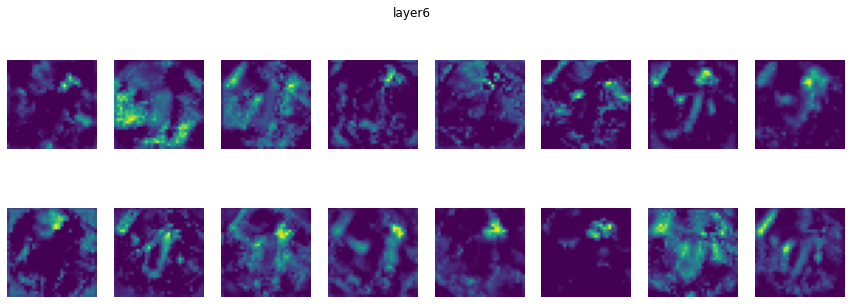

In [22]:
# Visualize the figure here, so it is exported nicely
plot_model_features()  

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [23]:
grader.check_all()

NameError: ignored